# Game instructions
Consider the following board game: A game board has 12 spaces. The swine senses the Christmas spirit and manages to run away from home couple of weeks beforehand. Fortunately for it, the butcher is a bit of a drunkard and easily distracted. The swine starts on space 7, and a butcher on space 1. On each game turn a 6-sided die is rolled. On a result of 1 to 3, the swine moves that many spaces forward. On a result of 5 or 6, the butcher moves that many spaces forward. On result 4, both advance one space forward. The swine wins if it reaches the river at space 12 (the final roll does not have to be exact, moving past space 12 is OK). The butcher wins if he catches up with the swine (or moves past it).

What are the probabilities of winning for the swine and the butcher?

Your assignment is to create a mathematical or statistical model to find these probabilities, and implement the solution as a computer program in whatever language you like. You will present it during the interview and we will discuss it with you. 

Consider the following questions as well: 
- Can you make your model easily extendable for different initial conditions (board size and initial positions)?
- Pros and cons of the approach?
- Can you say something about how long the game takes (also under different initial conditions)?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

pd.options.display.max_columns = 70
plt.style.use('ggplot')

# Model

#### Initiate game parameters

In [2]:
board_size = 12
swine_start = 7
butcher_start = 1

if butcher_start >= swine_start:
    raise ValueError('Error in starting positions: The swine has to start ahead of the butcher.')
elif swine_start >= board_size:
    raise ValueError('Error in starting positions: The river has to lie ahead of the swine.')

#### Create transition matrix

In [3]:
states = list(itertools.product(range(butcher_start, board_size + 1), range(swine_start, board_size + 1))) # Get state space.
states = list(itertools.compress(states, [i[0] <= i[1] for i in states])) # Filter out invalid states (butcher ahead of swine).
tm = pd.DataFrame(np.zeros(shape = (len(states), len(states))), index=states, columns=states) # Initiate transition matrix.

# Loop over states to fill in transition probabilities.
for b, s in states:
    
    # If someone already won, set as absorbing state.
    if s == board_size or b == s:
        tm.loc[[(b, s)], [(b, s)]] += 1
        continue
    
    # Die outcome 1.
    tm.loc[[(b, s)], [(b, s+1)]] += 1/6
    
    # Die outcome 2.
    if s+2 > board_size:
        tm.loc[[(b, s)], [(b, board_size)]] += 1/6
    else:
        tm.loc[[(b, s)], [(b, s+2)]] += 1/6
    
    # Die outcome 3.
    if s+3 > board_size:
        tm.loc[[(b, s)], [(b, board_size)]] += 1/6
    else:
        tm.loc[[(b, s)], [(b, s+3)]] += 1/6
    
    # Die outcome 4.
    tm.loc[[(b, s)], [(b+1, s+1)]] += 1/6 

     # Die outcome 5.
    if b+5 > s:
        tm.loc[[(b, s)], [(s, s)]] += 1/6
    else:
        tm.loc[[(b, s)], [(b+5, s)]] += 1/6

    # Die outcome 6.
    if b+6 > s:
        tm.loc[[(b, s)], [(s, s)]] += 1/6
    else:
        tm.loc[[(b, s)], [(b+6, s)]] += 1/6

#### Calculate winning chances

In [4]:
max_turns = (board_size - swine_start) + int((board_size - 2 - butcher_start)/5) # Calculate the maximum number of turns.
tm_final = pd.DataFrame(np.matrix(tm)**(max_turns), index = states, columns = states) # Get final transition matrix.

swine_win_prob = 0
butcher_win_prob = 0

for b, s in states:
    if b == s:
        butcher_win_prob += tm_final.get_value((butcher_start, swine_start), (b, s))
    else:
        swine_win_prob += tm_final.get_value((butcher_start, swine_start), (b, s))

In [5]:
print("If \n- the board size is {}, \n- the swine starts at position {}, \n- and the butcher starts at position {}, \nthen the swine's chance of escaping is {:.1f}% and the catch rate is {:.1f}%.".format(
    board_size, swine_start, butcher_start, swine_win_prob*100, butcher_win_prob*100))

If 
- the board size is 12, 
- the swine starts at position 7, 
- and the butcher starts at position 1, 
then the swine's chance of escaping is 51.2% and the catch rate is 48.8%.


#### Game length

In [6]:
game_length = pd.Series(np.zeros(shape = (max_turns)), index =  list(range(1, max_turns + 1)))

for t in range(1, max_turns+1):
    tm_temp = pd.DataFrame(np.matrix(tm)**t, index=states, columns=states) # Get transition matrix to turn t.
    
    # Add up probabilities of being in a final state.
    for b, s in states:
        if b == s:
            game_length.loc[t] += tm_temp.get_value((butcher_start, swine_start), (b, s))
        elif s == board_size:
            game_length.loc[t] += tm_temp.get_value((butcher_start, swine_start), (b, s))
    
    game_length.loc[t] -= sum(game_length.loc[:t-1]) # Subtract probability of reaching a final state in previous turns.
    
print('Average duration of the game: {:.3f} turns.'.format(np.dot(game_length.index, game_length)))

Average duration of the game: 2.998 turns.


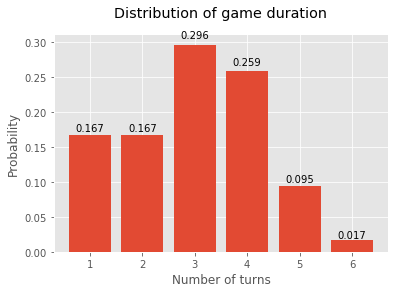

In [7]:
fig, ax = plt.subplots()
dist = ax.bar(game_length.index, game_length)

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.02*height,
                '%.3f' % height,
                ha='center', va='bottom')

autolabel(dist)
        
plt.xlabel('Number of turns')
plt.ylabel('Probability')
plt.title('Distribution of game duration', y = 1.05)
plt.show()